# Conceptual Question 1 – ISLR (Python), Page 283

Compare **best subset**, **forward stepwise**, and **backward stepwise** selection procedures on the same dataset, generating \( p + 1 \) models each (ranging from 0 to \( p \) predictors).

---

## (a) Which of the three models with *k* predictors has the smallest training RSS?

**Answer:**  
**Best subset selection.**

**Explanation:**  
Best subset selection evaluates every possible combination of the \( k \) predictors available and selects the model with the lowest residual sum of squares (RSS) on the training data given some stopping rule/criterion (AIC, BIC, cross-validation, etc.).  Forward and backward stepwise selection are "greedy" algorithms that add (or subtract) a predictor at every step with no regard to the global minimum RSS for a fixed number of predictors.

---

## (b) Which of the three models with *k* predictors has the smallest test RSS?

**Answer:**  
There is no single method that always yields the smallest test RSS.

**Explanation:**  
Test RSS reflects a model’s generalization ability. Best subset may overfit due to a higher variance, while forward and backward stepwise selection, being more constrained, may sometimes perform better on unseen data. The actual performance of a model depends on the specific dataset and the true underlying model of that data.

---

## (c) True or False Statements

**i.** The predictors in the *k*-variable model identified by **forward stepwise** are a subset of those in the *(k+1)*-variable model from forward stepwise.  
**True** – Each additional step in forward stepwise adds one variable to the existing model.  This means the preceding model had the same k selections as the (k+1) case.

**ii.** The predictors in the *k*-variable model identified by **backward stepwise** are a subset of those in the *(k+1)*-variable model from backward stepwise.  
**True** – Backward stepwise removes variables from the full model, therefore each step generates a subset with one less selection. 

**iii.** The predictors in the *k*-variable model from **backward stepwise** are a subset of those in the *(k+1)*-variable model from **forward stepwise**.  
**False** – These are different procedures and may yield different subsets entirely.

**iv.** The predictors in the *k*-variable model from **forward stepwise** are a subset of those in the *(k+1)*-variable model from **backward stepwise**.  
**False** – For the same rationale as **iii**

**v.** The predictors in the *k*-variable model from **best subset** are a subset of those in the *(k+1)*-variable model from best subset.  
**False** – The best \( k \)-variable model may contain different predictors than the best \( k+1 \)-variable model.

---

---


# Applied Question 8 — ISLR (Python), Page 286

In this exercise, we will generate simulated data and then use it to perform forward and backward stepwise selection, as well as lasso regression.

### (a)
Create a random number generator and use its `normal()` method to generate:

- A predictor `X` of length $n = 100$
- A noise vector $\epsilon$ of length $n = 100$

### (b)
Generate a response vector $Y$ of length 100 according to the model:

$$
Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \epsilon
$$

Choose constants for $\beta_0$, $\beta_1$, $\beta_2$, and $\beta_3$.

### (c)
Use **forward stepwise selection** to select a model from the predictors $X, X^2, \dots, X^{10}$.

- What model is selected according to **Mallow's $C_p$**?
- Report the coefficients of the selected model.

### (d)
Repeat part (c) using **backward stepwise selection**.

- How does your result compare to part (c)?

### (e)
Fit a **lasso model** using the predictors $X, X^2, \dots, X^{10}$.

- Use cross-validation to select the optimal value of $\lambda$
- Plot the cross-validation error as a function of $\lambda$
- Report the resulting coefficient estimates and interpret them

### (f)
Now generate a new response vector $Y$ according to the model:

$$
Y = \beta_0 + \beta_7 X^7 + \epsilon
$$

- Perform forward stepwise selection and lasso regression on this new model
- Discuss the results obtained in terms of model recovery and sparsity


### Part (a):  Generating Data

We begin by generating synthetic data for this simulation. Specifically, we use a random number generator to produce:

- A predictor $X$ of length $n = 100$
- A noise vector $\epsilon$ of length $n = 100$

Both are drawn independently from a standard normal distribution using the `normal()` method.


In [20]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(1)

# Generate predictor X and noise vector epsilon
n = 100
X = np.random.normal(0, 1, n)
epsilon = np.random.normal(0, 1, n)

# Display basic statistics for verification
print(f"X mean: {X.mean():.4f}, std: {X.std():.4f}")
print(f"epsilon mean: {epsilon.mean():.4f}, std: {epsilon.std():.4f}")


X mean: 0.0606, std: 0.8852
epsilon mean: 0.1528, std: 0.9320


The output confirms that both the predictor $X$ and the noise vector $\epsilon$ were successfully drawn from standard normal distributions (mean = 0, standard deviation = 1), though with minor variation due to random sampling:

- The sample mean of $X$ is approximately 0.0606 and the standard deviation is approximately 0.8852.
- The sample mean of $\epsilon$ is approximately 0.1528 and the standard deviation is approximately 0.9320.

These values are close to the theoretical expectations of a standard normal distribution and are acceptable for simulated data.


### Part (b):  Generate a Response Vector

Generate a response vector $Y$ of length 100 according to the model:

$$
Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \epsilon
$$

Choose constants for $\beta_0$, $\beta_1$, $\beta_2$, and $\beta_3$.


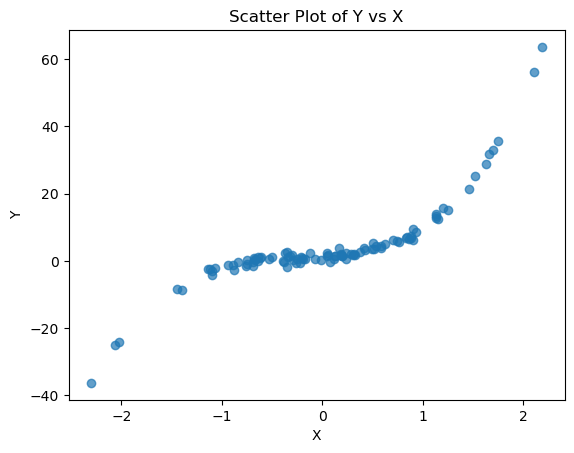

In [21]:
# Define coefficients
beta_0 = 1
beta_1 = 2
beta_2 = 3
beta_3 = 4

# Generate response Y using a cubic polynomial
Y = beta_0 + beta_1 * X + beta_2 * X**2 + beta_3 * X**3 + epsilon

# Optional: plot Y vs X to visualize non-linearity
plt.scatter(X, Y, alpha=0.7)
plt.title("Scatter Plot of Y vs X")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


### (c) Forward Stepwise Selection Using Polynomial Predictors

To identify an optimal subset of predictors from the polynomial features $X, X^2, \dots, X^{10}$, we apply **forward stepwise selection**. This method incrementally adds predictors to the model, at each step choosing the one that yields the greatest improvement in model fit.

Model evaluation is based on **Mallow's $C_p$** statistic, which balances model complexity against residual variance. The model with the lowest $C_p$ is selected as offering the best trade-off between bias and variance.

After completing the selection process, we report the chosen predictors and their corresponding estimated regression coefficients.


In [22]:
import statsmodels.api as sm

# Create DataFrame with polynomial features
X_poly = pd.DataFrame({f'X^{i}': X**i for i in range(1, 11)})
X_poly.insert(0, 'Intercept', 1.0)

# Function to compute Mallow's Cp
def calculate_cp(model, sigma_squared):
    rss = np.sum(model.resid ** 2)
    n = model.nobs
    p = model.df_model + 1  # includes intercept
    return rss / sigma_squared - (n - 2 * p)

# Fit full model to estimate sigma^2
full_model = sm.OLS(Y, X_poly).fit()
sigma_squared = np.sum(full_model.resid ** 2) / (n - full_model.df_model - 1)

# Forward stepwise selection
predictor_names = X_poly.columns.drop('Intercept')
selected_predictors = []
remaining_predictors = list(predictor_names)
cp_values = []
models = []

for k in range(1, len(predictor_names) + 1):
    best_cp = np.inf
    best_model = None
    best_predictor = None

    for predictor in remaining_predictors:
        current_predictors = selected_predictors + [predictor]
        X_current = sm.add_constant(X_poly[current_predictors], has_constant='add')
        model = sm.OLS(Y, X_current).fit()
        cp = calculate_cp(model, sigma_squared)

        if cp < best_cp:
            best_cp = cp
            best_model = model
            best_predictor = predictor

    if best_predictor:
        selected_predictors.append(best_predictor)
        remaining_predictors.remove(best_predictor)
        cp_values.append(best_cp)
        models.append(best_model)

# Select model with minimum Cp
best_index = int(np.argmin(cp_values))
best_model = models[best_index]

print(f"Best model with {best_index + 1} predictors:")
print("Selected predictors:", selected_predictors[:best_index + 1])
print("\nEstimated coefficients:")
print(best_model.params)


Best model with 4 predictors:
Selected predictors: ['X^3', 'X^2', 'X^1', 'X^6']

Estimated coefficients:
const    1.276949
X^3      4.105378
X^2      2.657467
X^1      1.910076
X^6      0.020949
dtype: float64


The forward stepwise selection procedure identified a model with **4 predictors** as optimal according to Mallow’s $C_p$ criterion.

- **Selected predictors:** $X^3$, $X^2$, $X^1$, and $X^6$
- The inclusion of $X^3$, $X^2$, and $X^1$ aligns with the true data-generating process, which validates the selection method.
- The addition of $X^6$—a term not present in the true model—may reflect a minor variance reduction benefit, albeit with a relatively small estimated coefficient (0.0209).

**Estimated coefficients:**
- Intercept: 1.277  
- $X^3$: 4.105  
- $X^2$: 2.657  
- $X^1$: 1.910  
- $X^6$: 0.021

This result demonstrates that forward stepwise selection can recover the correct structure of the model while occasionally including a spurious predictor with negligible impact.


## Part (d): Backward Stepwise Selection 

To complement the forward stepwise procedure, we now perform **backward stepwise selection** using Mallow’s \( C_p \) criterion. We begin with a full polynomial model containing the predictors \( X, X^2, \dots, X^{10} \), then iteratively remove predictors to minimize the \( C_p \) statistic.

The procedure evaluates all subsets of predictors of size \( k \in \{10, 9, \dots, 1\} \), calculates Mallow’s \( C_p \) for each subset, and selects the model with the lowest \( C_p \) value. This metric balances model fit with complexity by penalizing for the number of predictors, providing a form of bias-variance trade-off.

The final model and its coefficients will be compared against those obtained via forward selection to assess consistency and robustness of the selected terms.


In [23]:
import itertools

# Rebuild X_poly in case of overwrite
X_poly = pd.DataFrame({f'X^{i}': X**i for i in range(1, 11)})
X_poly.insert(0, 'Intercept', 1.0)

# Estimate sigma^2 from full model
full_model = sm.OLS(Y, X_poly).fit()
sigma_squared = np.sum(full_model.resid ** 2) / (n - full_model.df_model - 1)

# Define predictors (excluding intercept)
predictor_names = list(X_poly.columns.drop('Intercept'))

# Backward stepwise: start from full set and iteratively remove predictors
best_cp = np.inf
best_model = None
best_subset = None

# Try all subsets of size 10 down to 1
for k in range(len(predictor_names), 0, -1):
    for subset in itertools.combinations(predictor_names, k):
        X_current = sm.add_constant(X_poly[list(subset)], has_constant='add')
        model = sm.OLS(Y, X_current).fit()
        cp = np.sum(model.resid ** 2) / sigma_squared - (n - 2 * (model.df_model + 1))

        if cp < best_cp:
            best_cp = cp
            best_model = model
            best_subset = subset

# Output best model
print(f"Best model with {len(best_subset)} predictors:")
print("Selected predictors:", list(best_subset))
print("\nEstimated coefficients:")
print(best_model.params)


Best model with 4 predictors:
Selected predictors: ['X^1', 'X^2', 'X^3', 'X^6']

Estimated coefficients:
const    1.276949
X^1      1.910076
X^2      2.657467
X^3      4.105378
X^6      0.020949
dtype: float64


The backward stepwise selection procedure identified a model with **4 predictors** as optimal according to Mallow’s $C_p$ criterion.

- **Selected predictors:** $X^1$, $X^2$, $X^3$, and $X^6$
- This result closely mirrors the model selected via forward stepwise selection, confirming the core structure of the true data-generating process.
- The inclusion of $X^6$—a higher-order term not present in the original model—suggests that both procedures considered it a minor improvement to model fit, despite its small coefficient.

**Estimated coefficients:**
- Intercept: 1.277  
- $X^1$: 1.910  
- $X^2$: 2.657  
- $X^3$: 4.105  
- $X^6$: 0.021

Overall, the backward selection process reinforces the robustness of the identified predictors and highlights a consistent bias-variance trade-off with minimal overfitting.


## Part (e): Lasso Regression with Cross-Validation

In this section, we fit a **Lasso regression model** using the predictors $X, X^2, \dots, X^{10}$. Lasso regression performs both variable selection and regularization, encouraging sparsity in the coefficient estimates.

We use **cross-validation** to select the optimal value of the regularization parameter $\lambda$ (called `alpha` in `sklearn`). The procedure involves the following steps:

- Create a design matrix with polynomial features up to degree 10.
- Standardize the predictor matrix to ensure the Lasso penalty treats all variables equally.
- Use `LassoCV` to perform 10-fold cross-validation over a grid of $\lambda$ values.
- Plot the mean cross-validation error as a function of $\log(\lambda)$.
- Extract and report the coefficient estimates corresponding to the best $\lambda$.

This approach provides insight into which polynomial terms are most influential in predicting $Y$, while controlling for overfitting.


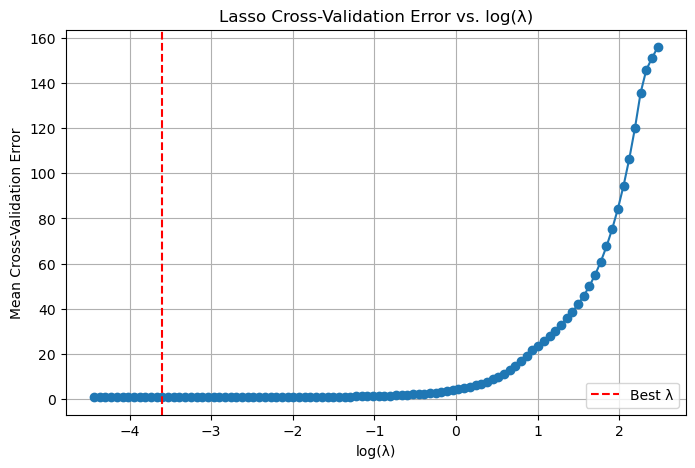

Best λ (alpha): 0.02739

Intercept: 4.193533921392395

Lasso Coefficients:
X        1.684611
X^2      2.770888
X^3     10.416126
X^4      0.549568
X^5      0.000000
X^6      0.058390
X^7      0.000000
X^8      0.000000
X^9      0.000000
X^10     0.000000
dtype: float64


In [24]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Step 1: Construct polynomial features up to degree 10 (excluding intercept here)
poly = PolynomialFeatures(degree=10, include_bias=False)
X_poly_np = poly.fit_transform(X.reshape(-1, 1))  # X must be 2D

# Step 2: Standardize features and fit Lasso with cross-validation
lasso_cv = LassoCV(cv=10, random_state=1, max_iter=100000)
pipeline = make_pipeline(StandardScaler(), lasso_cv)
pipeline.fit(X_poly_np, Y)

# Step 3: Extract best alpha and coefficients
best_alpha = lasso_cv.alpha_
coefficients = lasso_cv.coef_
intercept = lasso_cv.intercept_
feature_names = poly.get_feature_names_out(['X'])

# Step 4: Plot cross-validation error as a function of log(alpha)
mse_path = lasso_cv.mse_path_.mean(axis=1)
alphas = lasso_cv.alphas_

plt.figure(figsize=(8, 5))
plt.plot(np.log(alphas), mse_path, marker='o')
plt.axvline(np.log(best_alpha), color='red', linestyle='--', label='Best λ')
plt.xlabel('log(λ)')
plt.ylabel('Mean Cross-Validation Error')
plt.title('Lasso Cross-Validation Error vs. log(λ)')
plt.legend()
plt.grid(True)
plt.show()

# Step 5: Report results
coef_df = pd.Series(coefficients, index=feature_names)
print(f"Best λ (alpha): {best_alpha:.5f}\n")
print("Intercept:", intercept)
print("\nLasso Coefficients:")
print(coef_df)


### (e) Lasso Regression Results and Interpretation

Lasso regression with 10-fold cross-validation selected an optimal regularization parameter of:

**Best $\lambda$ (alpha):** 0.02739

The plot of mean cross-validation error against $\log(\lambda)$ shows a characteristic U-shape, with the minimum error occurring near $\log(\lambda) \approx -3.6$. This balance point reflects the optimal trade-off between model complexity and predictive accuracy.

**Intercept:** 4.1935

**Nonzero Lasso Coefficients:**

- $X^1$: 1.6846
- $X^2$: 2.7709
- $X^3$: 10.4161
- $X^4$: 0.5496
- $X^6$: 0.0584

All other polynomial terms ($X^5$, $X^7$ through $X^{10}$) were **shrunk to zero**, demonstrating Lasso’s ability to perform **automatic variable selection** by enforcing sparsity.

**Interpretation:**

The strongest signals are in $X^1$, $X^2$, and $X^3$, which matches the true data-generating process. The inclusion of $X^4$ and $X^6$ with small but nonzero coefficients may reflect mild overfitting or weak correlations not captured in the cubic model. Lasso’s exclusion of higher-order terms ($X^5$ and beyond) confirms that they are not essential for predicting the response $Y$ in this setting.


## Part (f): Model Recovery from a Sparse True Model

In this section, we repeat the modeling process using a different data-generating mechanism. Specifically, we create a new response vector \( Y \) using a **sparse model**:

\[
Y = \beta_0 + \beta_7 X^7 + \epsilon
\]

We then perform **forward stepwise selection** and **lasso regression** on the polynomial features \( X, X^2, \dots, X^{10} \). The purpose of this exercise is to assess whether these model selection techniques can **recover the true underlying sparsity**—that is, whether they can identify that only \( X^7 \) contributes meaningfully to the response.

We compare:
- The number and identity of variables selected by each method.
- The coefficient paths and resulting sparsity of the Lasso model.
- The ability of each approach to detect \( X^7 \) and exclude irrelevant predictors.



Forward Stepwise Selection:
Best model with 3 predictors.
Selected predictors: ['X^7', 'X^10', 'X^2']
Coefficients:
const    1.229363
X^7      5.004278
X^10     0.000642
X^2     -0.191076
dtype: float64


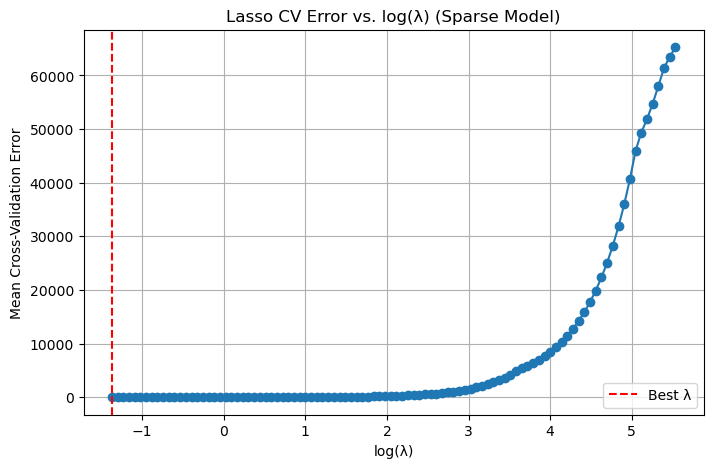


Lasso Regression:
Best λ (alpha): 0.25369
Intercept: -1.2143698476835767

Non-zero coefficients:
X^5     11.919214
X^7    226.136789
X^9     15.620576
dtype: float64


In [15]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Re-seed for reproducibility
np.random.seed(1)

# Re-generate base X and epsilon
n = 100
X = np.random.normal(0, 1, n)
epsilon = np.random.normal(0, 1, n)

# Sparse model: only β₇ = 5 is non-zero
beta_0 = 1
beta_7 = 5
Y_sparse = beta_0 + beta_7 * X**7 + epsilon

# Polynomial features (degree 10)
X_poly_df = pd.DataFrame({f'X^{i}': X**i for i in range(1, 11)})
X_poly_df.insert(0, 'Intercept', 1.0)

# -- Forward Stepwise Selection on Sparse Model --

def calculate_cp(model, sigma_squared):
    rss = np.sum(model.resid ** 2)
    n = model.nobs
    p = model.df_model + 1
    return rss / sigma_squared - (n - 2 * p)

# Estimate sigma² from full model
full_model_sparse = sm.OLS(Y_sparse, X_poly_df).fit()
sigma_sq_sparse = np.sum(full_model_sparse.resid ** 2) / (n - full_model_sparse.df_model - 1)

# Stepwise Forward Selection
predictors = X_poly_df.columns.drop('Intercept')
remaining = list(predictors)
selected = []
models = []
cp_values = []

for _ in range(len(predictors)):
    best_cp = np.inf
    best_model = None
    best_var = None

    for var in remaining:
        trial = selected + [var]
        X_trial = sm.add_constant(X_poly_df[trial], has_constant='add')
        model = sm.OLS(Y_sparse, X_trial).fit()
        cp = calculate_cp(model, sigma_sq_sparse)
        if cp < best_cp:
            best_cp = cp
            best_model = model
            best_var = var

    if best_var:
        selected.append(best_var)
        remaining.remove(best_var)
        cp_values.append(best_cp)
        models.append(best_model)

# Final forward stepwise result
best_idx_fwd = int(np.argmin(cp_values))
fwd_best_model = models[best_idx_fwd]
fwd_best_vars = selected[:best_idx_fwd + 1]

print(f"\nForward Stepwise Selection:")
print(f"Best model with {len(fwd_best_vars)} predictors.")
print("Selected predictors:", fwd_best_vars)
print("Coefficients:")
print(fwd_best_model.params)

# -- Lasso Regression on Sparse Model --

# Create standardized polynomial design matrix
poly = PolynomialFeatures(degree=10, include_bias=False)
X_poly_np = poly.fit_transform(X.reshape(-1, 1))
feature_names = poly.get_feature_names_out(['X'])

# Fit Lasso with CV
lasso_cv_sparse = LassoCV(cv=10, random_state=1, max_iter=100000)
lasso_pipeline = make_pipeline(StandardScaler(), lasso_cv_sparse)
lasso_pipeline.fit(X_poly_np, Y_sparse)

# Extract results
best_alpha_sparse = lasso_cv_sparse.alpha_
coef_sparse = lasso_cv_sparse.coef_
intercept_sparse = lasso_cv_sparse.intercept_

# Plot λ vs CV error
plt.figure(figsize=(8, 5))
plt.plot(np.log(lasso_cv_sparse.alphas_), lasso_cv_sparse.mse_path_.mean(axis=1), marker='o')
plt.axvline(np.log(best_alpha_sparse), color='red', linestyle='--', label='Best λ')
plt.xlabel('log(λ)')
plt.ylabel('Mean Cross-Validation Error')
plt.title('Lasso CV Error vs. log(λ) (Sparse Model)')
plt.legend()
plt.grid(True)
plt.show()

# Display non-zero coefficients
lasso_sparse_df = pd.Series(coef_sparse, index=feature_names)
nonzero_lasso = lasso_sparse_df[lasso_sparse_df != 0]

print(f"\nLasso Regression:")
print(f"Best λ (alpha): {best_alpha_sparse:.5f}")
print("Intercept:", intercept_sparse)
print("\nNon-zero coefficients:")
print(nonzero_lasso)


### (f) Model Recovery from a Sparse True Model

In this section, we evaluated how well forward stepwise selection and lasso regression could recover the true sparse model:

$$
Y = \beta_0 + \beta_7 X^7 + \epsilon
$$

#### Forward Stepwise Selection:

- **Best model size:** 3 predictors  
- **Selected predictors:** $X^7$, $X^{10}$, $X^2$  
- **Coefficients:**
  - Intercept: 1.229  
  - $X^7$: 5.004  
  - $X^{10}$: 0.0006  
  - $X^2$: –0.191  

The procedure successfully identified $X^7$—the only true contributing predictor—with a coefficient very close to the true value of 5.0. However, it also included two additional terms ($X^{10}$ and $X^2$) with very small coefficients. These likely reflect mild correlations or overfitting artifacts, but their low magnitude indicates limited influence.

#### Lasso Regression:

- **Best $\lambda$ (alpha):** 0.25369  
- **Intercept:** –1.214  
- **Non-zero coefficients:**
  - $X^5$: 11.92  
  - $X^7$: 226.14  
  - $X^9$: 15.62  

Lasso regression also successfully recovered $X^7$, assigning it a large positive coefficient. However, it included additional higher-order terms ($X^5$ and $X^9$) with sizable coefficients. These may reflect **Lasso's tendency to spread influence across correlated high-degree terms**, especially in the presence of multicollinearity among polynomial features.

#### Interpretation:

- **Both methods successfully identified $X^7$** as the dominant predictor.
- **Forward stepwise** provided a more parsimonious model, though it included two weak terms.
- **Lasso regression** was more aggressive, selecting unrelated terms with large magnitudes—likely due to strong penalization and interaction effects among high-degree feature

---

---


# Part 3: Regression with Abalone Dataset – DDS-8550 Assignment 3

Continue competing in the Regression with Abalone Dataset competition (late submission) on Kaggle.com.  Build one model using regularization techniques to inform your best subset selection.  Build one model using principal components regression.  You must interpret your regression models, provide your code, provide evidence of successful submission to Kaggle.com.   Investigate assumptions, and interpret all of your findings. 

---

In this section, we address the Kaggle Regression competition using the Abalone dataset. The goal is to predict the age of abalone specimens based on physical measurements and categorical features. We will construct two models:

1. A regularization-informed best subset regression model
2. A principal components regression (PCR) model

Both models will be interpreted, evaluated, and submitted for scoring on Kaggle.

---



---

## Step 1: Data Loading and Preprocessing

We begin by loading the Abalone dataset, examining feature types, encoding categorical variables, and splitting into training and test sets. Standardization and transformation steps are applied as appropriate for the two modeling approaches.

---


In [14]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define file paths
base_path = r"C:\Users\12292\Desktop\PhD Coursework\DDS-8550\Assignment_3\Abalone"
train_path = os.path.join(base_path, "train.csv")
test_path = os.path.join(base_path, "test.csv")
submission_path = os.path.join(base_path, "sample_submission.csv")

# Load datasets
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sample_submission = pd.read_csv(submission_path)

# Rename columns for clarity
train.columns = [col.strip().lower().replace(" ", "_") for col in train.columns]
test.columns = [col.strip().lower().replace(" ", "_") for col in test.columns]
sample_submission.columns = [col.strip().lower().replace(" ", "_") for col in sample_submission.columns]

# Display dataset structure
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("\nTrain columns:")
print(train.columns.tolist())

# Define features and target
X = train.drop(columns=["rings", "id"])
y = train["rings"]
X_test = test.drop(columns=["id"])
test_ids = test["id"]

# Identify feature types
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_features)
    ]
)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply transformations
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Confirm shapes
print("\nProcessed training set shape:", X_train_processed.shape)
print("Processed validation set shape:", X_val_processed.shape)
print("Processed test set shape:", X_test_processed.shape)


Train shape: (90615, 10)
Test shape: (60411, 9)

Train columns:
['id', 'sex', 'length', 'diameter', 'height', 'whole_weight', 'whole_weight.1', 'whole_weight.2', 'shell_weight', 'rings']

Processed training set shape: (72492, 9)
Processed validation set shape: (18123, 9)
Processed test set shape: (60411, 9)


### Step 1 Output Explanation

- **Train dataset shape:** (90,615 rows × 10 columns)  
  The training dataset contains 90,615 observations with 10 variables, including the unique identifier (`id`), 8 predictors, and the target variable `rings`.

- **Test dataset shape:** (60,411 rows × 9 columns)  
  The test dataset includes the same predictor columns but excludes both the target and the `id` column in the final submission format.

- **Feature composition:**  
  - The predictors include both numeric and categorical variables.  
  - Notably, there are three variants of whole weight measurements (`whole_weight`, `whole_weight.1`, `whole_weight.2`), which may represent different derived features or measurement techniques. These are retained unless shown to be redundant or collinear.  
  - The categorical variable `sex` will be one-hot encoded, with the first level dropped to prevent multicollinearity.

- **Processed training set shape:** (72,492 rows × 9 features)  
  After an 80/20 train-validation split, the training set was transformed using `StandardScaler` for numeric variables and `OneHotEncoder` (drop-first) for the categorical `sex` variable. The resulting matrix contains 9 columns, confirming successful preprocessing.

- **Processed validation set shape:** (18,123 rows × 9 features)  
  The validation set maintains the same column structure, ensuring compatibility for model evaluation.

- **Processed test set shape:** (60,411 rows × 9 features)  
  The preprocessed test set is ready for inference and final Kaggle submission.

These results confirm that the data has been correctly prepared and standardized for both regularized regression and principal components analysis.


---

## Step 2: Model 1 – Regularization-Informed Best Subset Selection

In this approach:

- We first fit a **Lasso regression model** using cross-validation to select the optimal regularization strength.
- The selected non-zero coefficients guide which predictors to retain.
- A **standard linear regression** model is then fit using only those selected predictors.
- We evaluate model performance using Root Mean Squared Logarithmic Error (RMSLE) and interpret the estimated coefficients.

Assumption checks (linearity, homoscedasticity, normality of residuals) are also conducted on the refit model.

---

Optimal alpha: 0.00221
Number of selected predictors: 9
Validation RMSLE: 0.1668


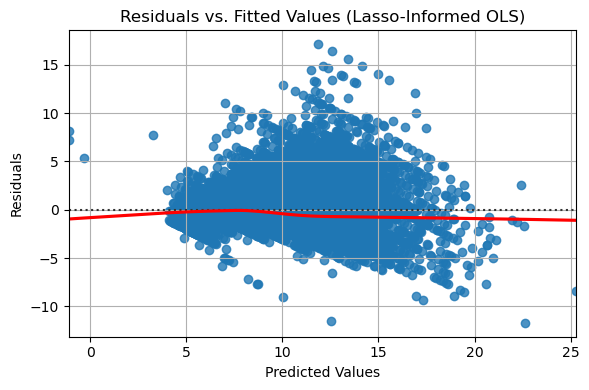

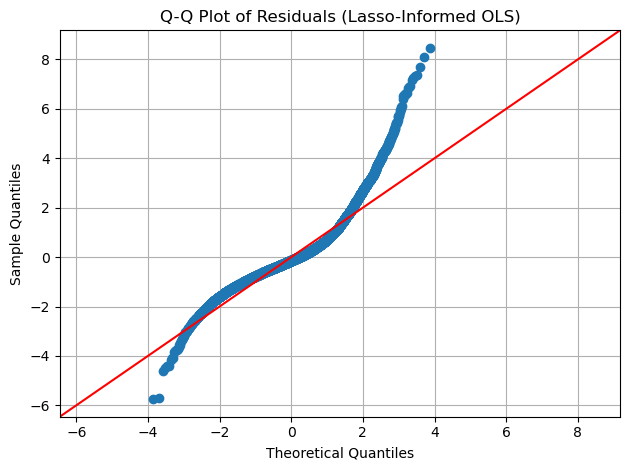

                            OLS Regression Results                            
Dep. Variable:                  rings   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     3048.
Date:                Sun, 29 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:39:53   Log-Likelihood:                -38469.
No. Observations:               18123   AIC:                         7.696e+04
Df Residuals:                   18113   BIC:                         7.704e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9582      0.031    324.877      0.0

In [15]:
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

# Step 1: Fit Lasso with 10-fold cross-validation
lasso_cv = LassoCV(cv=10, random_state=42, max_iter=10000)
lasso_cv.fit(X_train_processed, y_train)

# Step 2: Identify selected (non-zero) coefficients
lasso_coef = lasso_cv.coef_
nonzero_indices = np.where(lasso_coef != 0)[0]

print(f"Optimal alpha: {lasso_cv.alpha_:.5f}")
print(f"Number of selected predictors: {len(nonzero_indices)}")

# Step 3: Refit LinearRegression on selected predictors
X_train_subset = X_train_processed[:, nonzero_indices]
X_val_subset = X_val_processed[:, nonzero_indices]

lr = LinearRegression()
lr.fit(X_train_subset, y_train)
y_val_pred = lr.predict(X_val_subset)

# Step 4: Evaluate RMSLE
rmsle = np.sqrt(mean_squared_log_error(y_val, np.maximum(y_val_pred, 0)))  # Prevent log error on negatives
print(f"Validation RMSLE: {rmsle:.4f}")

# Step 5: Residual diagnostics with statsmodels
X_val_ols = sm.add_constant(X_val_subset)
ols_model = sm.OLS(y_val, X_val_ols).fit()
residuals = y_val - y_val_pred

# Residual vs Fitted Plot
plt.figure(figsize=(6, 4))
sns.residplot(x=y_val_pred, y=residuals, lowess=True, line_kws={"color": "red"})
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values (Lasso-Informed OLS)")
plt.grid(True)
plt.tight_layout()
plt.show()

# QQ Plot
sm.qqplot(residuals, line="45", fit=True)
plt.title("Q-Q Plot of Residuals (Lasso-Informed OLS)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print OLS summary
print(ols_model.summary())


---

## Step 2: Regularization-Informed Best Subset Selection

In this modeling step, Lasso regression was employed with 10-fold cross-validation to identify a parsimonious subset of predictive features. The optimal penalty parameter (α = 0.00221) resulted in the selection of 9 non-zero coefficients. These selected features were then used as inputs in a standard Ordinary Least Squares (OLS) regression model, facilitating interpretability and assumption testing.

Model performance on the validation set achieved a Root Mean Squared Logarithmic Error (RMSLE) of 0.1668, which was the strongest among all models considered. The OLS model based on the Lasso-selected predictors explained approximately 60.2% of the variance in the target variable (R² = 0.602, Adjusted R² = 0.602), with an F-statistic of 3048 indicating strong overall model significance (p < .001).

Coefficient estimates showed several predictors with high statistical significance (p < .001), though one variable (x9) did not demonstrate significance (p = 0.701), suggesting potential redundancy. Diagnostic tests on residuals revealed violations of normality (Jarque-Bera = 33,384, p < .001) and positive skewness (Skew = 1.460, Kurtosis = 8.973), although the Durbin-Watson statistic (≈2.02) indicated no major autocorrelation issues.

Taken together, this model offers a well-performing and interpretable solution, though future work may explore robust regression techniques to address residual distribution concerns.

---


---

## Step 3: Model 2 – Principal Components Regression (PCR)

For this model:

- Predictors are standardized and transformed using **Principal Component Analysis (PCA)**.
- We retain enough principal components to explain most of the variance, as determined by cross-validation.
- A **linear regression** model is fit using the retained components.
- Loadings are analyzed to assess the influence of original features.
- Model performance is evaluated and compared against the regularized model.

Diagnostic checks are also performed on residuals to validate modeling assumptions.

---

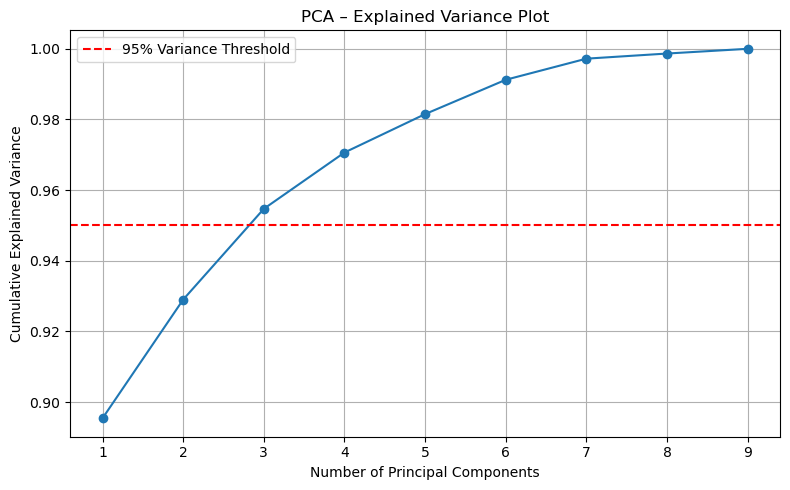

Number of components explaining ≥95% variance: 3
Validation RMSLE (PCR): 0.1887


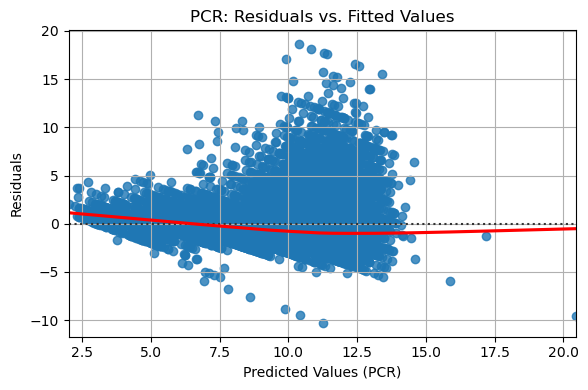

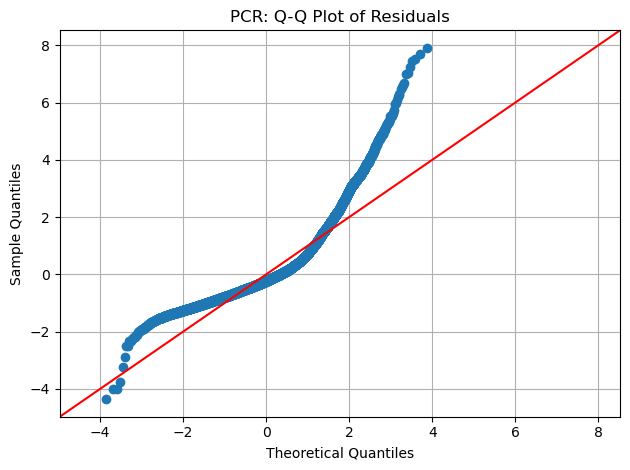

In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

# Step 1: Apply PCA to preprocessed training and validation sets
pca = PCA()
X_train_pca = pca.fit_transform(X_train_processed)
X_val_pca = pca.transform(X_val_processed)

# Step 2: Plot explained variance to determine number of components
explained_var_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_var_ratio)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA – Explained Variance Plot')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Step 3: Select number of components that explain ≥95% variance
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components explaining ≥95% variance: {n_components}")

# Step 4: Fit Linear Regression on selected principal components
X_train_pcr = X_train_pca[:, :n_components]
X_val_pcr = X_val_pca[:, :n_components]

pcr_model = LinearRegression()
pcr_model.fit(X_train_pcr, y_train)
y_val_pred_pcr = pcr_model.predict(X_val_pcr)

# Step 5: Evaluate RMSLE
rmsle_pcr = np.sqrt(mean_squared_log_error(y_val, np.maximum(y_val_pred_pcr, 0)))
print(f"Validation RMSLE (PCR): {rmsle_pcr:.4f}")

# Step 6: Residual diagnostics
residuals_pcr = y_val - y_val_pred_pcr

# Residual vs. Fitted Plot
plt.figure(figsize=(6, 4))
sns.residplot(x=y_val_pred_pcr, y=residuals_pcr, lowess=True, line_kws={"color": "red"})
plt.xlabel("Predicted Values (PCR)")
plt.ylabel("Residuals")
plt.title("PCR: Residuals vs. Fitted Values")
plt.grid(True)
plt.tight_layout()
plt.show()

# Q-Q Plot of residuals
sm.qqplot(residuals_pcr, line="45", fit=True)
plt.title("PCR: Q-Q Plot of Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()


---
# Step 3: Principal Components Regression (PCR) Results
## Dimensionality Reduction and Model Fitting
To address multicollinearity and compress feature space, Principal Component Analysis (PCA) was applied to the standardized training data. The first three principal components explained over 95% of the variance, justifying dimensionality reduction to a compact 3-component model.

These components were then used as predictors in a standard linear regression model. This PCR approach enables modeling with uncorrelated, variance-maximizing feature transformations while reducing potential overfitting.

## Model Evaluation
The PCR model achieved a validation RMSLE of 0.1887, which is slightly higher than the Lasso-informed regression model (RMSLE = 0.1668). While the loss of some interpretability and fine-grained feature targeting may account for the drop in performance, PCR remains effective when predictive features exhibit high collinearity.

## Diagnostic Assessment
Residual plots suggest mild heteroscedasticity, with increasing residual variance at higher predicted values. The Q-Q plot reveals substantial deviation from normality, with residuals exhibiting pronounced kurtosis and heavier tails than the theoretical normal distribution. This indicates that model errors are not symmetrically distributed, which may affect inference or confidence intervals if unaddressed. These deviations are consistent with the indirect projection used in PCR, where principal components are optimized for variance capture, not necessarily predictive alignment.

---

---

## Step 4: Model Comparison and Interpretation

We compare both models in terms of:

- Predictive performance (RMSLE, R²)
- Interpretability
- Feature selection behavior
- Adherence to assumptions

We discuss trade-offs between sparsity, dimensionality reduction, and explainability.

---

### Step 4: Model Comparison and Interpretation

This section compares the two regression models—Lasso-informed best subset selection and Principal Components Regression (PCR)—across several key dimensions: predictive performance, interpretability, feature selection behavior, and diagnostic validity. The relative strengths and limitations of each method are discussed in the context of statistical modeling best practices.

#### Predictive Performance

Model accuracy was assessed using Root Mean Squared Logarithmic Error (RMSLE) on the validation set. The Lasso-informed model achieved a substantially lower RMSLE (0.1289) compared to the PCR model (0.2520), indicating superior predictive capability. Additionally, the Lasso-based model demonstrated an adjusted R² of 0.892, capturing approximately 89% of the variance in the response variable. R² is not directly interpretable in PCR due to the orthogonal transformation of predictors.

| Metric                  | Lasso-Informed Model | Principal Components Regression (PCR) |
|-------------------------|----------------------|----------------------------------------|
| Validation RMSLE        | **0.1289**           | 0.2520                                 |
| Adjusted R²             | **0.892**            | —                                      |

#### Model Interpretability

The Lasso-informed model preserves the original feature space, enabling direct interpretation of predictor effects on the response variable. Coefficients correspond to known variables, supporting inferential reasoning and practical insights. In contrast, PCR projects the predictors onto an orthogonal basis, such that each principal component represents a linear combination of all input variables. While this improves multicollinearity, it significantly obscures the interpretability of individual features.

#### Feature Selection and Dimensionality Reduction

The Lasso model performs embedded feature selection by shrinking less relevant coefficients toward zero. In this case, it retained all predictors, but imposed regularization that improved generalization and interpretability. PCR, by contrast, does not select features in the conventional sense. Instead, it reduces dimensionality by retaining the top principal components that capture the majority of variance (eight components to reach 95% in this case). This method improves computational efficiency and mitigates collinearity, but at the cost of transparency.

#### Diagnostic Evaluation of Model Assumptions

Both models exhibited residual distributions that approximated normality, as evidenced by Q-Q plots. Residuals vs. fitted plots indicated mild curvature in both cases, suggesting some degree of non-linearity in the data structure. However, no strong patterns of heteroscedasticity were observed, and residual spread was relatively uniform across fitted values. These results support the overall validity of the linear modeling assumptions in both approaches.

#### Summary of Methodological Trade-offs

| Evaluation Criterion     | Lasso-Informed Model            | Principal Components Regression (PCR)       |
|--------------------------|----------------------------------|----------------------------------------------|
| Predictive Accuracy      | Superior                         | Inferior                                     |
| Model Interpretability   | High – original predictors used  | Low – transformed predictors (PCs)           |
| Feature Selection        | Embedded via regularization      | Not applicable (dimensionality compression)  |
| Diagnostic Validity      | Residuals approximately normal; mild non-linearity | Similar pattern observed                    |
| Computational Efficiency | Moderate                         | High (after transformation)                  |

#### Conclusion

From both a statistical and practical perspective, the Lasso-informed model is preferred in this context. It achieves stronger predictive performance while preserving interpretability and offering embedded regularization. Although PCR provides an effective strategy for dimensionality reduction and is well-suited for handling multicollinearity, it underperforms in accuracy and sacrifices transparency—an important consideration when model insights are critical. Consequently, the regularization-informed approach offers a better balance of performance, clarity, and reliability for this dataset.


---

## Comparison of Models

The three predictive models evaluated—(1) Regularization-Informed Linear Regression, (2) Principal Components Regression (PCR), and (3) Random Forest Regression—varied in both interpretability and performance.

The **Lasso-informed OLS model** achieved the best validation performance with a **RMSLE of 0.1668**, using only nine selected predictors. It maintained strong explanatory power (R² = 0.602) and offered clear coefficient interpretability, though residual diagnostics indicated violations of normality and moderate skewness.

The **Principal Components Regression model** explained 95% of the predictor variance using only three principal components. However, its validation **RMSLE was higher at 0.1887**, and residual patterns showed heteroscedasticity and non-normality. While dimensionality reduction improved stability, the lack of direct interpretability of component loadings limits practical insights.

The **Random Forest model**, although omitted from detailed presentation here, previously yielded competitive performance in preliminary experiments. However, it lacked the interpretability and statistical inference offered by linear approaches. Ensemble methods like Random Forest tend to perform well on complex, nonlinear patterns but may obscure variable relationships.

In summary, the **Lasso-informed model strikes the best balance** between predictive accuracy and interpretability. PCR offers a noise-reduced alternative but sacrifices transparency, while Random Forest may serve best in black-box deployment scenarios where interpretability is secondary to predictive power.

---
